In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import seaborn as sns
import sys
import os
import re
sys.path.append('/Users/w76m851/github_workspace/spicy-snow/')
from datetime import datetime

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters


In [4]:
def calc_rmse(lidar, insar):
    return(np.sqrt(((lidar-insar)**2).sum()/len(lidar)))

def calc_bias(lidar, insar):
    return (lidar-insar).mean()

dirs = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/*'))
site_names = [s.split('regional/')[1] for s in dirs]
results_df = pd.DataFrame(index=site_names, columns=['min_bias','params'])
sdsd
for name in site_names:
    print(datetime.now(), f'-- starting {name}')
    files = sorted(glob(f'/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/{name}/*.npy'))
    lidar_f = files[-1]
    # b constant at 1.0
    # files = [f for f in files if '_1.0_' in f]
    
    if files:
        lidar = np.load(lidar_f)
        # min_rmse = 9999
        min_bias = 9999
        min_params = ''
        for f in files[:-1]:
            insar = np.load(f)
            # rmse = calc_rmse(lidar, insar)
            bias = calc_bias(lidar, insar)
            # if rmse < min_rmse:
            #     min_rmse = rmse
            #     min_params = f.split('/')[-1]
            if abs(bias) < abs(min_bias):
                min_bias = bias
                min_params = f.split('/')[-1]

        results_df.loc[name] = [min_bias, min_params]



results_df[['a','b','c']] = [(a, b, c.split('.npy')[0]) for (a, b, c) in results_df['params'].str.split('_')]
results_df.drop(columns='params', inplace=True)
results_df.to_csv('bias_results_20230513.csv')

# npy_dirs = glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/*/')
# npy_dirs
# for d in npy_dirs[:1]:
#     files = sorted(glob(d+'*.npy', recursive=True))

# print(d, files)


NameError: name 'sdsd' is not defined

In [20]:
# Optimize params based on regional bias
file_list = sorted(glob(f'/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/Banner_2020-02-18/*.npy'))
npy_ext = [f.split('/')[-1] for f in file_list]
dir_prefix = '/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/'

min_bias = 9999
min_params = ''

for params in npy_ext[:-1]:
    spicy_list = []
    lidar_list = []
    
    # Load data from all sites
    for name in site_names:
        spicy_list.extend(np.load(f'{dir_prefix}{name}/{params}'))
        lidar_list.extend(np.load(f'{dir_prefix}{name}/lidar.npy'))

    bias = calc_bias(np.array(lidar_list), np.array(spicy_list))
    if abs(bias) < abs(min_bias):
        min_bias = bias
        min_params = params

In [21]:
min_params

'2.5_0.2_0.55.npy'

In [22]:
from sklearn.metrics import mean_squared_error

colnames = ['B_20_params','B_21_params','C_21_params','DC_20_params', 'F_20_params',
            'F_21_params','LC_21_params','M_20_params','M_21_params']
opt_params_rmse = pd.read_csv('../../results/site_param_rmses/varying_all.csv', index_col=0).sort_index()
# For bias results
# opt_params_rmse = pd.read_csv('bias_results_20230513.csv', index_col=0).sort_index()
# opt_params_rmse.drop(columns='min_bias', inplace=True)

results_rmse = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)
results_bias = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)

opt_params_rmse.index = colnames
opt_params_rmse.loc['Lievens', ['a','b','c']] = [2, 0.5, 0.44]
opt_params_rmse.loc['Regional', ['a','b','c']] = [2.5, 1, 0.33]
# print('Optimal params:\n', opt_params_rmse)

dirs = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/*'))
site_names = [s.split('regional/')[1] for s in dirs]

for name in site_names:
    print(datetime.now(), f'-- starting {name}')
    site_dir = sorted(glob(f'/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/{name}/'))[0]
    lidar_f = site_dir + 'lidar.npy'
    lidar = np.load(lidar_f)
    for col, (a, b, c) in opt_params_rmse[['a','b','c']].iterrows():
        insar = np.load(site_dir + f'{a}_{b}_{c}.npy')
        rmse = mean_squared_error(lidar, insar, squared = False) #calc_rmse(lidar, insar)
        bias = calc_bias(lidar, insar)
        # if col == 'Lievens':
            # print(f'Lievens params: {a}, {b}, {c}\nRMSE: {rmse}\nBias: {bias}')
        results_rmse.loc[name, col] = rmse
        results_bias.loc[name, col] = bias

results_rmse.to_csv('heatmap_rmse_opt_params_rmse.csv')
results_bias.to_csv('heatmap_bias_opt_params_rmse.csv')


colnames = ['B_20_params','B_21_params','C_21_params','DC_20_params', 'F_20_params',
            'F_21_params','LC_21_params','M_20_params','M_21_params']
# opt_params_rmse = pd.read_csv('../../results/site_param_rmses/varying_all.csv', index_col=0).sort_index()
# For bias results
opt_params_rmse = pd.read_csv('bias_results_20230513.csv', index_col=0).sort_index()

results_rmse = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)
results_bias = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)

opt_params_rmse.index = colnames
opt_params_rmse.loc['Lievens', ['a','b','c']] = [2, 0.5, 0.44]
opt_params_rmse.loc['Regional', ['a','b','c']] = [2.5, 0.2, 0.55]
# print('Optimal params:\n', opt_params_rmse)

dirs = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/*'))
site_names = [s.split('regional/')[1] for s in dirs]

for name in site_names:
    print(datetime.now(), f'-- starting {name}')
    site_dir = sorted(glob(f'/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/{name}/'))[0]
    lidar_f = site_dir + 'lidar.npy'
    lidar = np.load(lidar_f)
    for col, (a, b, c) in opt_params_rmse[['a','b','c']].iterrows():
        insar = np.load(site_dir + f'{a}_{b}_{c}.npy')
        rmse = mean_squared_error(lidar, insar, squared = False) #calc_rmse(lidar, insar)
        bias = calc_bias(lidar, insar)
        # if col == 'Lievens':
            # print(f'Lievens params: {a}, {b}, {c}\nRMSE: {rmse}\nBias: {bias}')
        results_rmse.loc[name, col] = rmse
        results_bias.loc[name, col] = bias


results_rmse.to_csv('heatmap_rmse_opt_params_bias.csv')
results_bias.to_csv('heatmap_bias_opt_params_bias.csv')


2023-05-17 12:31:51.055380 -- starting Banner_2020-02-18
2023-05-17 12:31:51.101657 -- starting Banner_2021-03-15
2023-05-17 12:31:51.144693 -- starting Cameron_2021-03-19
2023-05-17 12:31:51.171762 -- starting Dry_Creek_2020-02-19
2023-05-17 12:31:51.196999 -- starting Frasier_2020-02-11
2023-05-17 12:31:51.230218 -- starting Frasier_2021-03-19
2023-05-17 12:31:51.268375 -- starting Little_Cottonwood_2021-03-18
2023-05-17 12:31:51.295789 -- starting Mores_2020-02-09
2023-05-17 12:31:51.321244 -- starting Mores_2021-03-15
2023-05-17 12:31:51.359749 -- starting Banner_2020-02-18
2023-05-17 12:31:51.392425 -- starting Banner_2021-03-15
2023-05-17 12:31:51.421799 -- starting Cameron_2021-03-19
2023-05-17 12:31:51.445352 -- starting Dry_Creek_2020-02-19
2023-05-17 12:31:51.470095 -- starting Frasier_2020-02-11
2023-05-17 12:31:51.496980 -- starting Frasier_2021-03-19
2023-05-17 12:31:51.528708 -- starting Little_Cottonwood_2021-03-18
2023-05-17 12:31:51.549506 -- starting Mores_2020-02-09


In [144]:
for col, (a, b, c) in opt_params_rmse[['a','b','c']].iterrows():
    print(col, a, b, c)

B_20_params 1.5 1.0 0.7
B_21_params 2.5 1.0 0.27
C_21_params 1.0 1.0 1.0
DC_20_params 3.0 1.0 0.27
F_20_params 1.0 1.0 0.97
F_21_params 1.0 1.0 0.65
LC_21_params 3.0 1.0 0.32
M_20_params 3.0 1.0 0.37
M_21_params 1.5 1.0 0.56
Lievens 2.0 0.5 0.44
Regional 2.5 1.0 0.33


In [99]:
# Old, slow version

colnames = ['B_20_params','B_21_params','C_21_params','DC_20_params', 'F_20_params',
            'F_21_params','LC_21_params','M_20_params','M_21_params']
# opt_params_rmse = pd.read_csv('../../results/site_param_rmses/varying_all.csv', index_col=0).sort_index()
# For bias results
opt_params_rmse = pd.read_csv('bias_results_20230513.csv', index_col=0).sort_index()
# opt_params_rmse.drop(columns='min_bias', inplace=True)

results_rmse = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)
results_bias = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)

opt_params_rmse.index = colnames
opt_params_rmse.loc['Lievens', ['a','b','c']] = [2, 0.5, 0.44]
opt_params_rmse.loc['Regional', ['a','b','c']] = [2.5, 1, 0.33]

files = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/*.nc'))

for f in files:
    ds_ = xr.open_dataset(f).load()
    ds_name = f.split('stacks/')[-1].split('.')[0]
    ds = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(ds.time) - pd.to_datetime(ds.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = ds.time[closest_ts_idx]
    if 'Frasier_2020-02-11.nc' in f:
        closest_ts = '2020-02-16T13:09:43'
    
    for col, (a, b, c) in opt_params_rmse[['a','b','c']].iterrows():
        ds_param = retrieval_from_parameters(ds, A=a, B=b, C=c).sel(time=closest_ts)
        mask_wet = ~(pd.isnull(ds_param['lidar-sd']) | pd.isnull(ds_param['snow_depth']) | ds_param['wet_snow'].astype(bool))
        diff_wet = ds_param['lidar-sd'].where(mask_wet) - ds_param['snow_depth'].where(mask_wet)
        rmse = float(np.sqrt((diff_wet**2).sum()/sum(~pd.isnull(diff_wet.values.flatten()))))
        results_rmse.loc[ds_name, col] = rmse
        results_bias.loc[ds_name, col] = float(diff_wet.mean())

In [137]:
results_rmse.to_csv('heatmap_rmse_opt_params_rmse.csv')
results_bias.to_csv('heatmap_rmse_opt_params_rmse.csv')

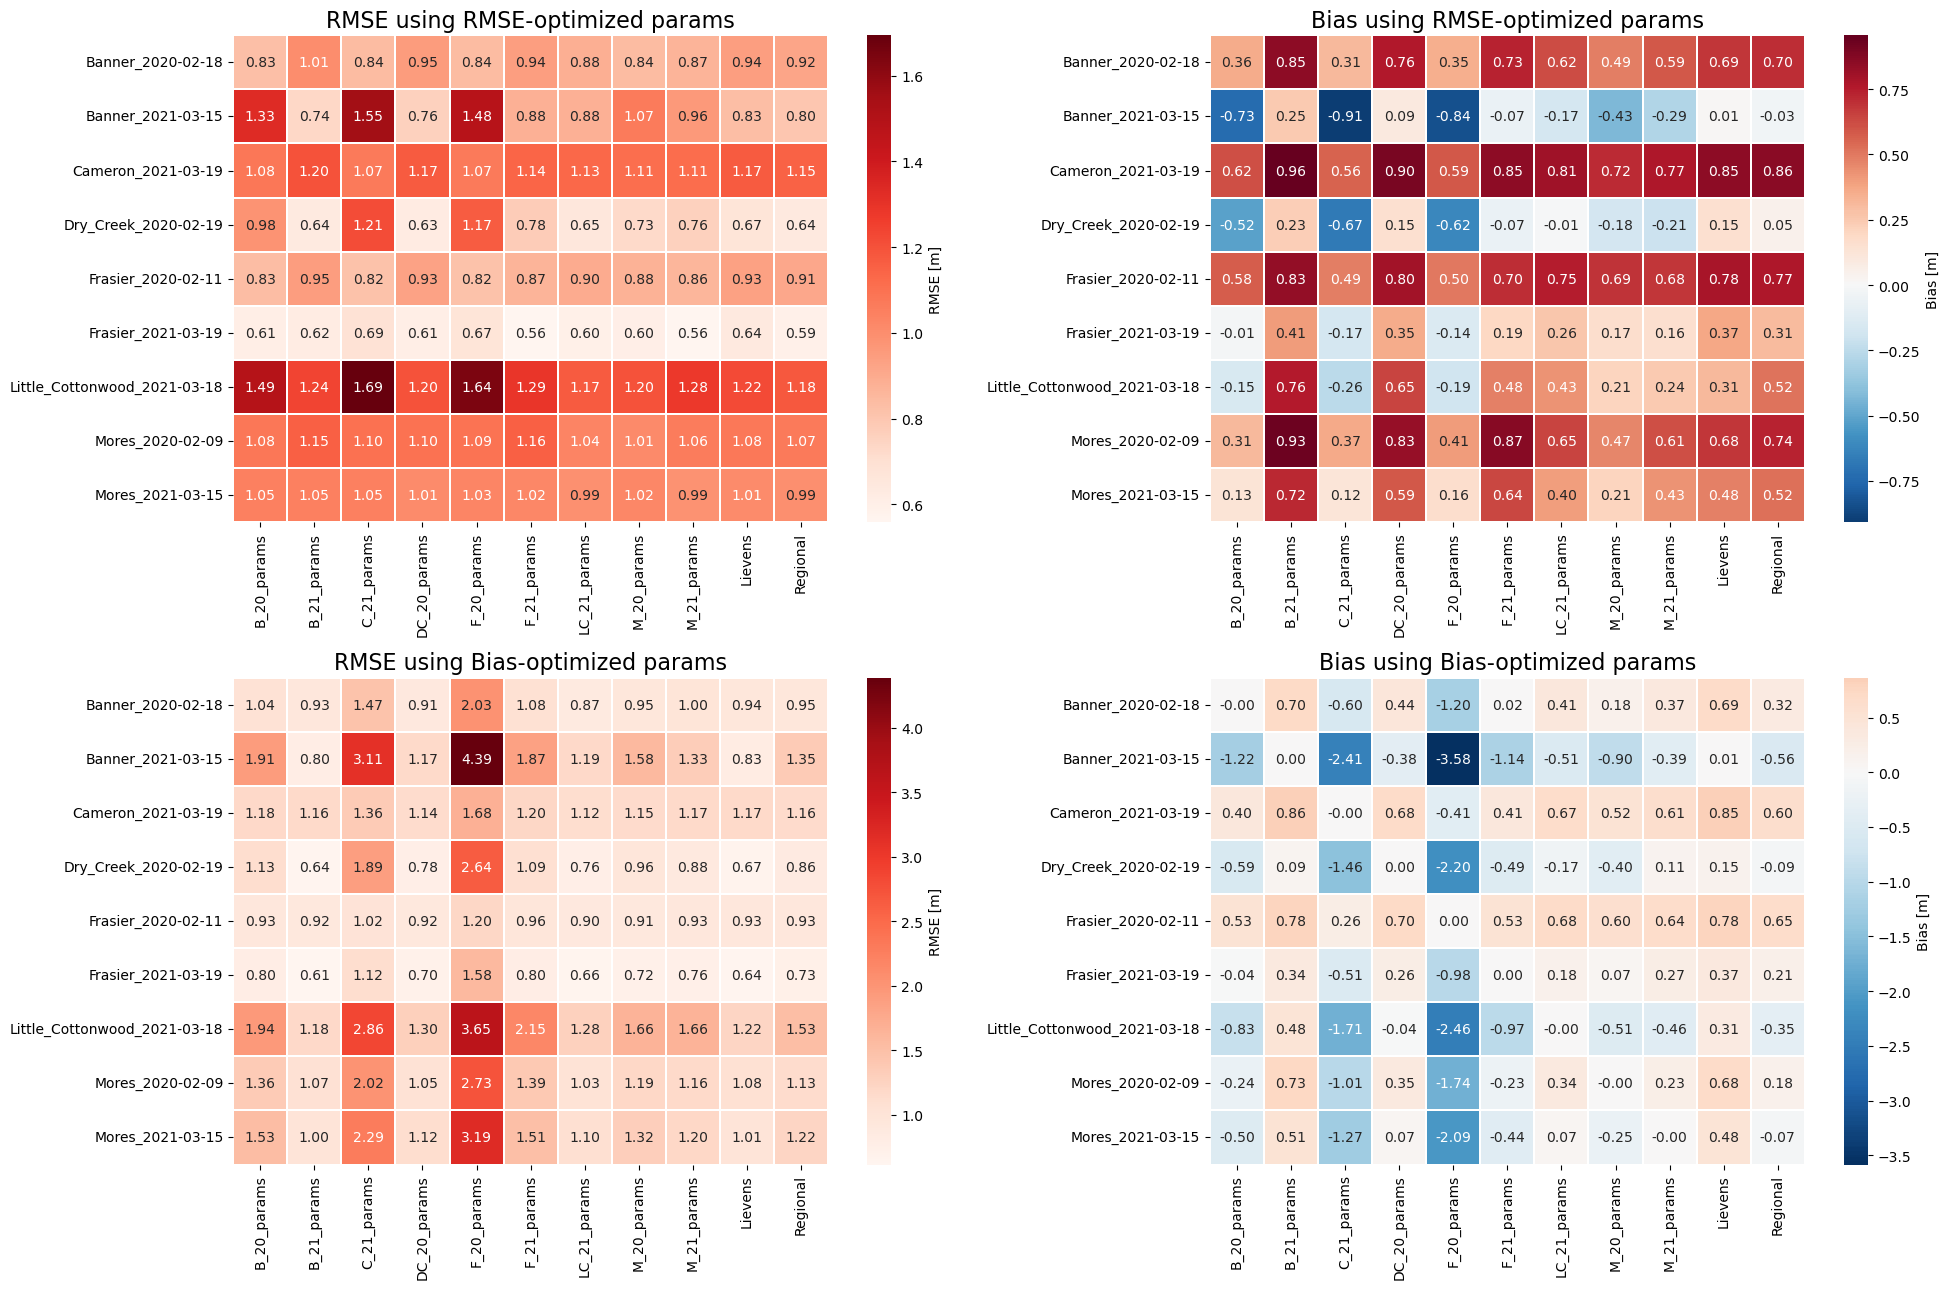

In [23]:
rmse_rmse = pd.read_csv('heatmap_rmse_opt_params_rmse.csv', index_col=0)
bias_rmse = pd.read_csv('heatmap_bias_opt_params_rmse.csv', index_col=0)
rmse_bias = pd.read_csv('heatmap_rmse_opt_params_bias.csv', index_col=0)
bias_bias = pd.read_csv('heatmap_bias_opt_params_bias.csv', index_col=0)


fig, ax = plt.subplots(2,2, figsize=(20,13))
sns.heatmap(rmse_rmse, cmap='Reds', annot=True, square=True, fmt='.2f',
            linewidths=0.2, cbar_kws={'label':'RMSE [m]'}, ax=ax[0,0])
sns.heatmap(bias_rmse, cmap='RdBu_r', annot=True, fmt='.2f', center=0, square=True,
            linewidths=0.2, cbar_kws={'label':'Bias [m]'}, ax=ax[0,1])
sns.heatmap(rmse_bias, cmap='Reds', annot=True, square=True, fmt='.2f',
            linewidths=0.2, cbar_kws={'label':'RMSE [m]'}, ax=ax[1,0])
sns.heatmap(bias_bias, cmap='RdBu_r', annot=True, fmt='.2f', center=0, square=True,
            linewidths=0.2, cbar_kws={'label':'Bias [m]'}, ax=ax[1,1])

ax[0,0].set_title('RMSE using RMSE-optimized params', fontsize=16)
ax[0,1].set_title('Bias using RMSE-optimized params', fontsize=16)
ax[1,0].set_title('RMSE using Bias-optimized params', fontsize=16)
ax[1,1].set_title('Bias using Bias-optimized params', fontsize=16)

plt.tight_layout()


In [5]:
fig.savefig('rmse_bias_heatmaps.png', facecolor='white', dpi=300)

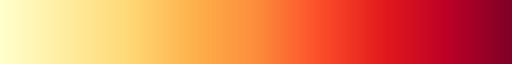

In [7]:
plt.get_cmap('YlOrRd')

In [ ]:
from sklearn.metrics import mean_squared_error

colnames = ['B_20_params','B_21_params','C_21_params','DC_20_params', 'F_20_params',
            'F_21_params','LC_21_params','M_20_params','M_21_params']
opt_params_rmse = pd.read_csv('../../results/site_param_rmses/varying_all.csv', index_col=0).sort_index()
# For bias results
# opt_params_rmse = pd.read_csv('bias_results_20230513.csv', index_col=0).sort_index()
# opt_params_rmse.drop(columns='min_bias', inplace=True)

results_rmse = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)
results_bias = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)

opt_params_rmse.index = colnames
opt_params_rmse.loc['Lievens', ['a','b','c']] = [2, 0.5, 0.44]
opt_params_rmse.loc['Regional', ['a','b','c']] = [2.5, 1, 0.33]
# print('Optimal params:\n', opt_params_rmse)

dirs = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/*'))
site_names = [s.split('regional/')[1] for s in dirs]

for name in site_names:
    print(datetime.now(), f'-- starting {name}')
    site_dir = sorted(glob(f'/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/{name}/'))[0]
    lidar_f = site_dir + 'lidar.npy'
    lidar = np.load(lidar_f)
    for col, (a, b, c) in opt_params_rmse[['a','b','c']].iterrows():
        insar = np.load(site_dir + f'{a}_{b}_{c}.npy')
        rmse = mean_squared_error(lidar, insar, squared = False) #calc_rmse(lidar, insar)
        bias = calc_bias(lidar, insar)
        if col == 'Lievens':
            print(f'Lievens params: {a}, {b}, {c}\nRMSE: {rmse}\nBias: {bias}')
        results_rmse.loc[name, col] = rmse
        results_bias.loc[name, col] = bias

results_rmse.to_csv('heatmap_rmse_opt_params_rmse_skl.csv')
results_bias.to_csv('heatmap_bias_opt_params_rmse_skl.csv')


colnames = ['B_20_params','B_21_params','C_21_params','DC_20_params', 'F_20_params',
            'F_21_params','LC_21_params','M_20_params','M_21_params']
# opt_params_rmse = pd.read_csv('../../results/site_param_rmses/varying_all.csv', index_col=0).sort_index()
# For bias results
opt_params_rmse = pd.read_csv('bias_results_20230513.csv', index_col=0).sort_index()

results_rmse = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)
results_bias = pd.DataFrame(index=opt_params_rmse.index, columns=colnames)

opt_params_rmse.index = colnames
opt_params_rmse.loc['Lievens', ['a','b','c']] = [2, 0.5, 0.44]
opt_params_rmse.loc['Regional', ['a','b','c']] = [2.5, 1, 0.33]
# print('Optimal params:\n', opt_params_rmse)

dirs = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/*'))
site_names = [s.split('regional/')[1] for s in dirs]

for name in site_names:
    print(datetime.now(), f'-- starting {name}')
    site_dir = sorted(glob(f'/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/param_regional/{name}/'))[0]
    lidar_f = site_dir + 'lidar.npy'
    lidar = np.load(lidar_f)
    for col, (a, b, c) in opt_params_rmse[['a','b','c']].iterrows():
        insar = np.load(site_dir + f'{a}_{b}_{c}.npy')
        rmse = mean_squared_error(lidar, insar, squared = False) #calc_rmse(lidar, insar)
        bias = calc_bias(lidar, insar)
        if col == 'Lievens':
            print(f'Lievens params: {a}, {b}, {c}\nRMSE: {rmse}\nBias: {bias}')
        results_rmse.loc[name, col] = rmse
        results_bias.loc[name, col] = bias


results_rmse.to_csv('heatmap_rmse_opt_params_bias_skl.csv')
results_bias.to_csv('heatmap_bias_opt_params_bias_skl.csv')
